# Let's study the Edinburgh STL landscape
Our dataset is defined with:
- `data/listings.csv` from [insideairbnb.com](insideairbnb.com)
- `data/Edinburgh_Ward_Boundaries.geojson` from [https://data.edinburghcouncilmaps.info/datasets/dc96624b1db849db926f59806e287d44_24/about](https://data.edinburghcouncilmaps.info/datasets/dc96624b1db849db926f59806e287d44_24/about)
- `data/licenses.csv` from [public registry](https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fwww.edinburgh.gov.uk%2Fdownloads%2Ffile%2F32198%2Fshort-term-lets&wdOrigin=BROWSELINK)
- `data/map_to_coords.csv`, this I reacreated with [geoapify](geoapify.com)

In [8]:
import pandas as pd
import geopandas as gpd
import json

bnbs = pd.read_csv('data/listings.csv')

g_bnbs = gpd.GeoDataFrame(
    bnbs, geometry=gpd.points_from_xy(bnbs.longitude, bnbs.latitude), crs='EPSG:4326'
)

edinburgh = gpd.read_file('data/Edinburgh_Ward_Boundaries.geojson')
edinburgh = edinburgh[['Ward_Name','geometry']]
edinburgh.Ward_Name = [x.replace(' / ', '/') for x in edinburgh.Ward_Name]
edinburgh.Ward_Name = [x.replace('/ ', '/') for x in edinburgh.Ward_Name]
edinburgh.Ward_Name = [x.replace('Morningside', 'Meadows/Morningside') for x in edinburgh.Ward_Name]
g_bnbs = gpd.sjoin(g_bnbs, edinburgh, how="inner", predicate="within")
g_bnbs = g_bnbs.rename(columns={'Ward_Name': 'ward'})
points_per_ward = g_bnbs.groupby('ward').size()

Let us see that the data makes some sense

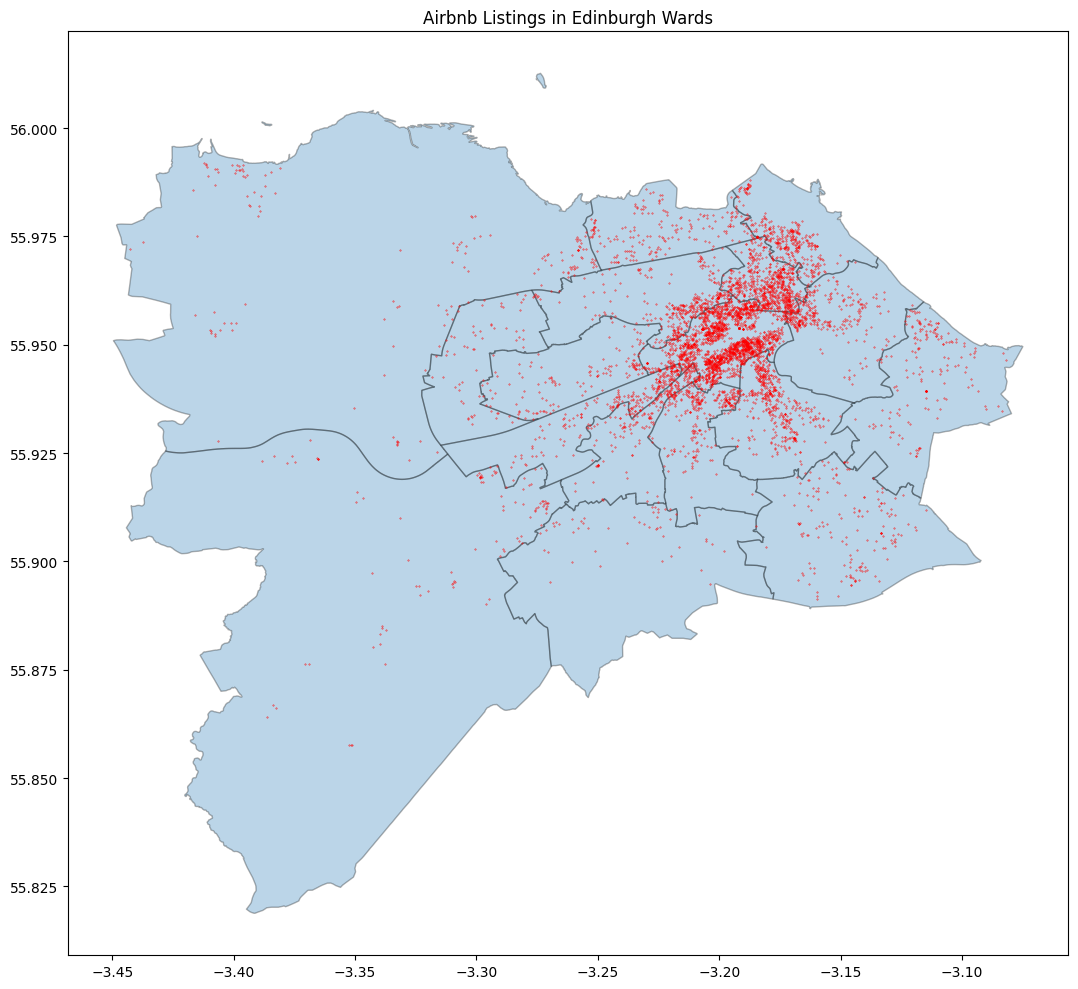

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

edinburgh.plot(ax=ax, alpha=0.3, edgecolor='k')

g_bnbs.plot(ax=ax, color='red', markersize=0.1)

plt.title('Airbnb Listings in Edinburgh Wards')
plt.tight_layout()
plt.show()

In [10]:
lincenses = pd.read_csv('data/licenses.csv', encoding_errors='ignore', header=1, parse_dates=True, date_format="%d-%b-%y")
lincenses = lincenses.rename(columns={
    "Date Received": "date_recieved", 
    "Date Considered Valid": "date_considered", 
    "Decision Date": "date_decision", 
    "Expiry Date": "date_expiry", 
    "Short Term Let category": "category",
    "Applicant - If company or Organisation": "company",
    "Premises address": "address",
    "Postcode ": "postcode",
    "Council Ward": "ward",
    "Status": "status",
    "Decision": "decision",
    "Short Term Let Type": "type",
    "Manager": "manager"
})
lincenses = lincenses[["date_recieved", "date_considered", "date_decision","date_expiry", "category", "company", "address", "postcode", "ward", "status", "decision", "type", "manager"]]
lincenses['full_address'] = lincenses['address'] + ', ' + lincenses['postcode']

lincenses.ward = [x.replace('/ ', '/') if type(x) == str else x for x in lincenses.ward]

for col in ["date_recieved", "date_considered", "date_decision","date_expiry"]:
    lincenses[col] = pd.to_datetime(lincenses[col], format='%d-%b-%y')

licenses_valid = lincenses[(lincenses.date_expiry > pd.Timestamp.today()) & (lincenses.status == 'Licence issued')]
licenses_valid.head()

date_recieved date_considered date_decision date_expiry  \
195    2025-04-03      2025-04-03    2025-04-25  2025-07-13   
198    2025-04-03      2025-04-03    2025-04-24  2025-08-31   
217    2025-04-01      2025-04-01    2025-04-23  2025-07-17   
218    2025-04-01      2025-04-01    2025-04-24  2025-08-28   
232    2025-04-01      2025-04-01    2025-04-17  2025-11-22   

                category                           company  \
195    Temporary licence                               NaN   
198  Temporary exemption                               NaN   
217    Temporary licence                               NaN   
218  Temporary exemption                               NaN   
232      Renewed licence  The Rosebery Estates Partnership   

                                               address  postcode         ward  \
195       1f2, 38 Cockburn Street, Old Town, Edinburgh   EH1 1PB  City Centre   
198        2f1, 18 Spittal Street, Old Town, Edinburgh   EH3 9DT  City Centre   
217         1f2, 18 Leopold Place, Hillside, Edinburgh   EH7 5LB   Leith Walk   
218         1f2, 18 Leopold Place, Hillside, Edinburgh   EH7 5LB   Leith Walk   
232  The Water Tower, Easter Dalmeny, Dalmeny, Sout...  EH30 9TS       Almond   

             status       decision                           type  \
195  Licence issued  Grant Licence  Home letting and home sharing   
198  Licence issued  Grant Licence              Secondary letting   
217  Licence issued  Grant Licence              Secondary letting   
218  Licence issued  Grant Licence              Secondary letting   
232  Licence issued  Grant Licence              Secondary letting   

                  manager                                       full_address  
195                   NaN  1f2, 38 Cockburn Street, Old Town, Edinburgh, ...  
198                   NaN  2f1, 18 Spittal Street, Old Town, Edinburgh, E...  
217  Ms Christine Lorimer  1f2, 18 Leopold Place, Hillside, Edinburgh, EH...  
218  Ms Christine Lorimer  1f2, 18 Leopold Place, Hillside, Edinburgh, EH...  
232    Ms Siobhan Forrest  The Water Tower, Easter Dalmeny, Dalmeny, Sout...

## Looking at counts

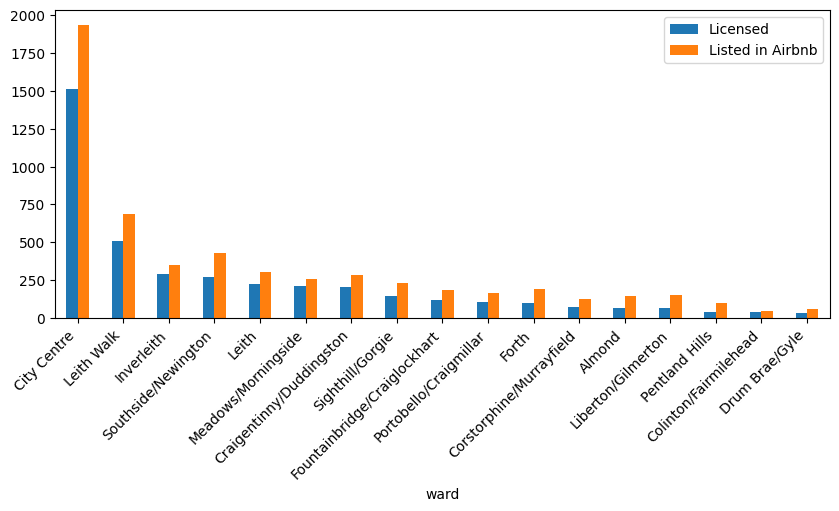

                              Licensed  Listed in Airbnb
ward                                                    
City Centre                       1513              1935
Leith Walk                         509               690
Inverleith                         290               349
Southside/Newington                274               432
Leith                              223               306
Meadows/Morningside                214               261
Craigentinny/Duddingston           202               286
Sighthill/Gorgie                   143               231
Fountainbridge/Craiglockhart       118               183
Portobello/Craigmillar             103               166
Forth                               99               191
Corstorphine/Murrayfield            75               129
Almond                              69               147
Liberton/Gilmerton                  66               151
Pentland Hills                      38                98
Colinton/Fairmilehead          

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))

comparison_by_ward = pd.concat([licenses_valid.ward.value_counts(), points_per_ward], axis=1)
comparison_by_ward = comparison_by_ward.rename(columns={'count':'Licensed', 0:'Listed in Airbnb'})
comparison_by_ward.plot.bar(ax=ax)
plt.xticks(rotation=45, ha='right')

plt.show()
print(comparison_by_ward)
print(comparison_by_ward.sum())

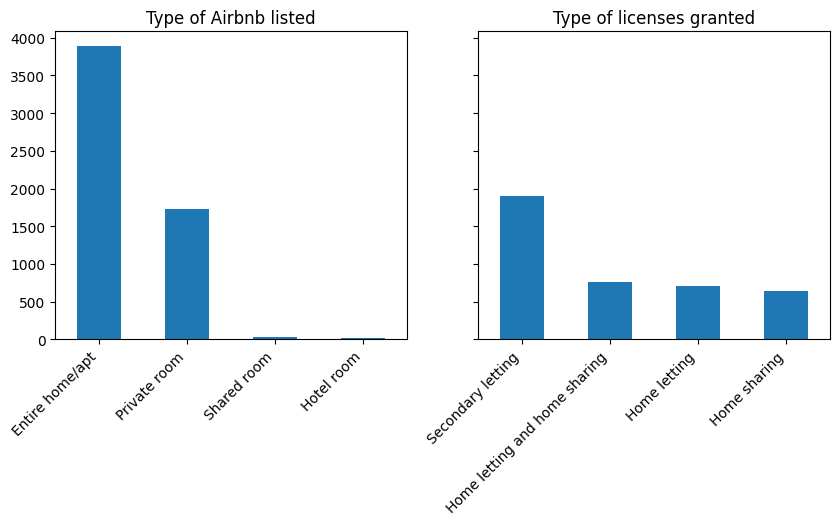

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10, 4),sharey=True)

g_bnbs.room_type.value_counts().plot.bar(ax=ax[0])
licenses_valid.type.value_counts().plot.bar(ax=ax[1])

ax[0].set_xticks(ax[0].get_xticks(), ax[0].get_xticklabels(), rotation=45, ha='right')
ax[0].set_xlabel('')
ax[0].set_title('Type of Airbnb listed')
ax[1].set_xticks(ax[1].get_xticks(), ax[1].get_xticklabels(), rotation=45, ha='right')
ax[1].set_xlabel('')
ax[1].set_title('Type of licenses granted')


plt.show()

In [13]:
g_bnbs.room_type.value_counts()

room_type
Entire home/apt    3889
Private room       1726
Shared room          30
Hotel room           21
Name: count, dtype: int64

## Looking and managers and hosts

In [14]:
def clean_name(name): # need this because sometimes people have a middle name or not, but it is the same person
    if type(name) == float:
        return name
    names = name.split()
    if names[0] in ['Mr', 'Mrs', 'Ms', 'Miss', 'Dr']:
        names.pop(0)
    
    return ' '.join([names[0],names[-1]])


licenses_valid.loc[:,'clean_name'] =  [clean_name(x) for x in licenses_valid.manager]

print('License managers:')
print(licenses_valid.clean_name.value_counts())
print('\nAirbnb hosts:')
print(g_bnbs.host_id.value_counts())

License managers:
clean_name
John Moffat          73
William Parry        59
Barry Burton         58
Louise Brook         35
Craig Douglas        33
                     ..
Andrew King           1
Katie Bartholomew     1
Angela Hutt           1
Marita Arah           1
Anna Wallace          1
Name: count, Length: 1367, dtype: int64

Airbnb hosts:
host_id
37563463     102
3008499       51
344268039     47
646220        46
201600360     45
            ... 
225412105      1
253093706      1
307126869      1
29783383       1
32424807       1
Name: count, Length: 3452, dtype: int64


/tmp/ipykernel_30143/3879415503.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  licenses_valid.loc[:,'clean_name'] =  [clean_name(x) for x in licenses_valid.manager]


We can use look at the nasty manager like Rebecca Webster, who has 18 valid licenses and 51 airbnb listings, this can be found with https://www.airbnb.co.uk/rooms/658402416478317071

In [15]:
print(f'Rebecca Webster has {licenses_valid.clean_name.value_counts()["Rebecca Webster"]} licenses and {g_bnbs.host_id.value_counts()[3008499]} airbnbs')

Rebecca Webster has 18 licenses and 51 airbnbs


In [16]:
print(f'Joivy Scotland has {licenses_valid.clean_name.str.contains("Altido", na=False).sum()} licenses and {g_bnbs.host_id.value_counts()[37563463]} airbnbs')

Joivy Scotland has 41 licenses and 102 airbnbs


## Trying to map listings to licenses

In [17]:
map_coord = pd.read_csv('data/map_to_coords.csv')

map_coord = gpd.GeoDataFrame(
    map_coord, geometry=gpd.points_from_xy(map_coord.lon, map_coord.lat), crs="EPSG:4326"
)

licenses_valid_with_geometry = licenses_valid.join(map_coord.set_index('full_address'), on='full_address')
licenses_valid_with_geometry = licenses_valid_with_geometry[licenses_valid_with_geometry.geometry.notna()]

licenses_valid_with_geometry = gpd.GeoDataFrame(
    licenses_valid_with_geometry, 
    geometry='geometry',
    crs="EPSG:4326"
)

joined = gpd.sjoin(licenses_valid_with_geometry, edinburgh, how="inner", predicate="within")

licenses_valid_with_geometry = licenses_valid_with_geometry.loc[joined.index]

It's really hard to match a license to a listing, because we don't have the exact address of the listings

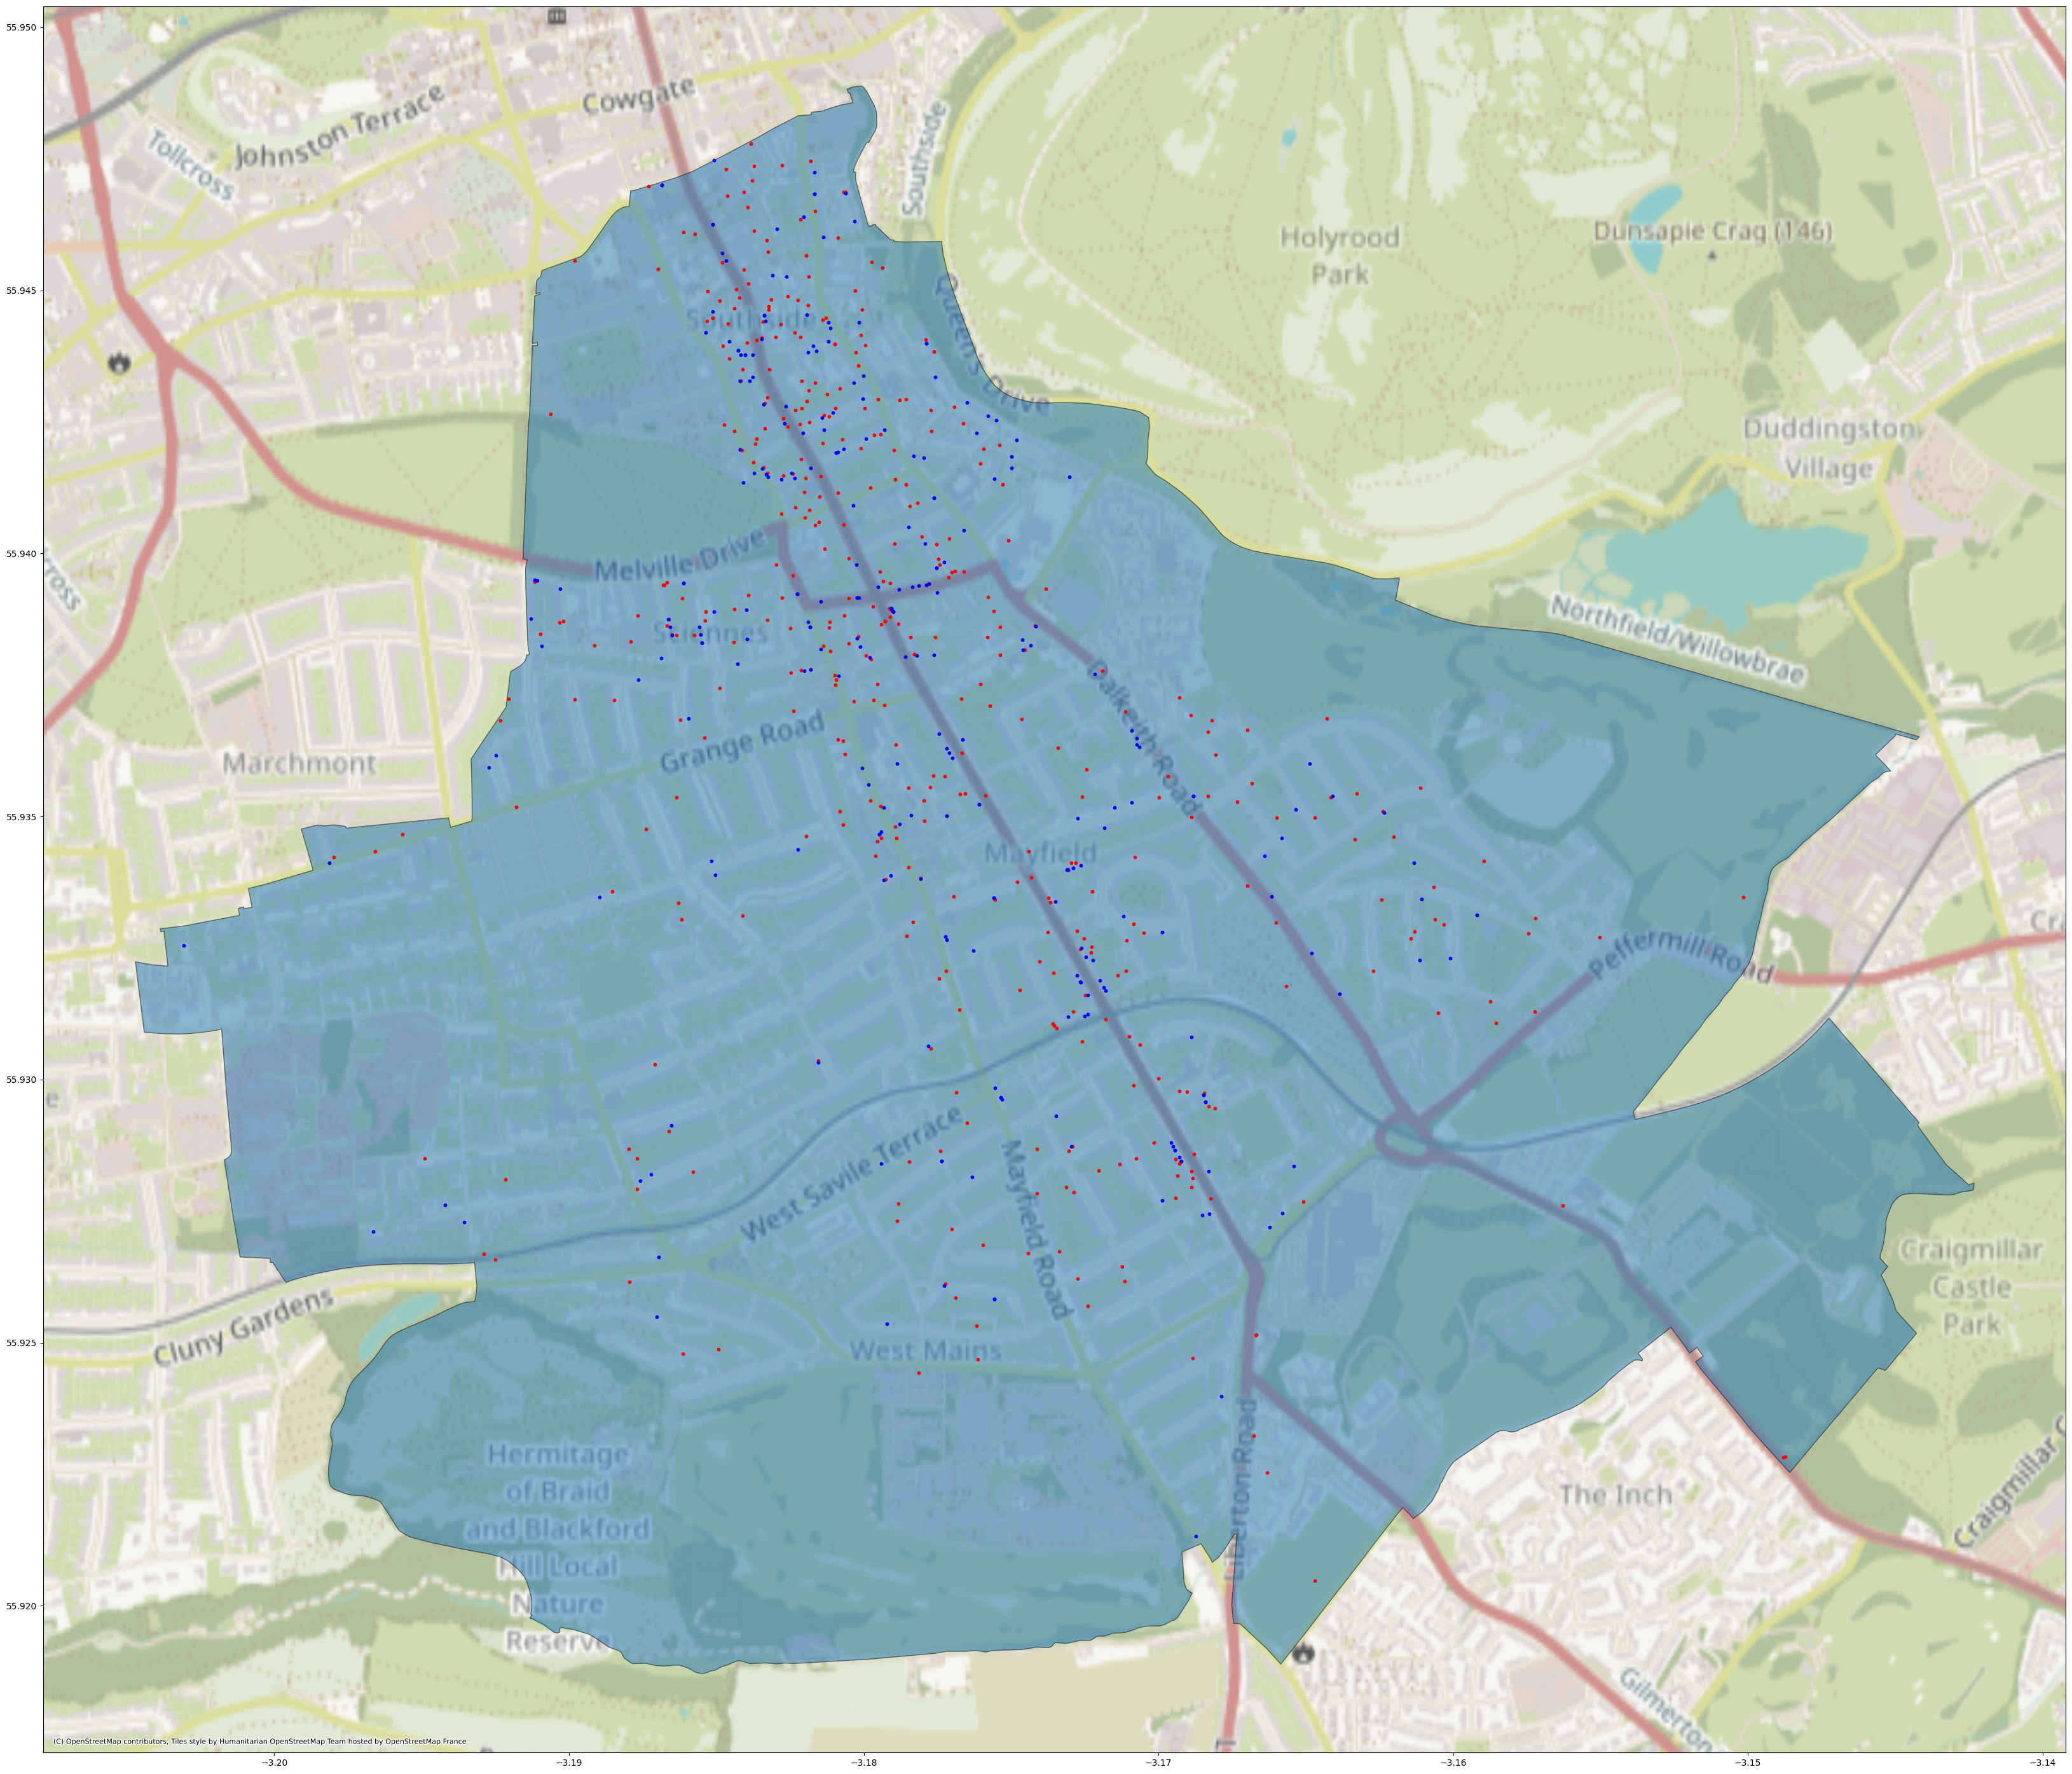

In [19]:
import matplotlib.pyplot as plt
import contextily as cx

fig, ax = plt.subplots(figsize=(40, 28), dpi=100)

edinburgh[edinburgh.Ward_Name == 'Southside/Newington'].plot(ax=ax, alpha=0.5, edgecolor='k')

g_bnbs[g_bnbs.ward == 'Southside/Newington'].geometry.plot(ax=ax, color='red', markersize=10)
licenses_valid_with_geometry[licenses_valid_with_geometry.ward == 'Southside/Newington'].geometry.plot(ax=ax, color='blue', markersize=10)
cx.add_basemap(ax, crs=edinburgh.crs)

plt.tight_layout()
plt.show()